In [42]:
from segmentation.model.frame import Framework
from segmentation.data.slice import get_tiff_np, read_shp, read_tiff, get_mask
import segmentation.model.functions as fn
from segmentation.model.metrics import *
def get_tp_fp_fn(pred, true):
    pred, true = torch.from_numpy(pred), torch.from_numpy(true)
    tp, fp, fn = tp_fp_fn(pred, true)
    return tp, fp, fn

def get_precision_recall_iou(tp, fp, fn):
    p, r, i = precision(tp, fp, fn), recall(tp, fp, fn), IoU(tp, fp, fn)
    return p, r, i

import yaml
import pathlib
import rasterio
import rasterio.plot
import torch
import pdb
from addict import Dict
import numpy as np
import pandas as pd
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_fill_holes
from PIL import Image
from tqdm import tqdm

import seaborn_image as isns

In [15]:
conf = Dict(yaml.safe_load(open('./conf/predict_slices.yaml')))

#% Prediction-specific config
runs_dir = pathlib.Path(conf.runs_dir)
output_dir = pathlib.Path(conf.output_dir)

#% Load checkpoint using the training config
checkpoint_path = runs_dir / conf.run_name / 'models' / 'model_best.pt'
frame: Framework = Framework.from_checkpoint(checkpoint_path, device=int(conf.gpu_rank), testing=True)

#% Load data stuff
tiff_path = pathlib.Path('/home/jperez/data/HKH_raw/Landsat7_2005/')
dem_path = pathlib.Path('/home/jperez/data/HKH_raw/DEM/')
labels_fname = pathlib.Path('/home/jperez/data/HKH_raw/labels/HKH_CIDC_5basins_all.shp')
labels = read_shp(labels_fname)

#% Extract the useful variables we want from the frame and config
data_dir = pathlib.Path(frame.loader_opts.processed_dir)
normalize:str = frame.loader_opts.normalize
use_channels = frame.loader_opts.use_channels
is_binary = len(frame.loader_opts.output_classes) == 1
binary_class_idx = frame.loader_opts.output_classes[0]
total_classes = len(frame.loader_opts.class_names)
df = pd.read_csv(data_dir / 'slice_meta.csv')

arr = np.load(data_dir / "normalize_train.npy")
if normalize == "mean-std":
    _mean, _std = arr[0], arr[1]
if normalize == "min-max":
    _min, _max = arr[2], arr[3]

assert len(conf.threshold) == total_classes

UNET dropout= 1e-08


organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.


In [3]:
# Sentinel-2 data
tiff_fname = pathlib.Path('/data/jperez/Sentinel/image8.tif')
tiff_np = get_tiff_np(tiff_fname, None, physics_res=None, physics_scale=None, verbose=True)
print(tiff_np.shape, f'{tiff_np.nbytes/1e6:.2f} MBs = {tiff_np.nbytes/1e9:.2f} GBs of RAM needed')

use_dem=False, use_physics=False
(4373, 4926, 16) 1378.65 MBs = 1.38 GBs of RAM needed


In [4]:
tiff_np = np.dstack((tiff_np, np.zeros((tiff_np.shape[0], tiff_np.shape[1]))))

(4373, 4926, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


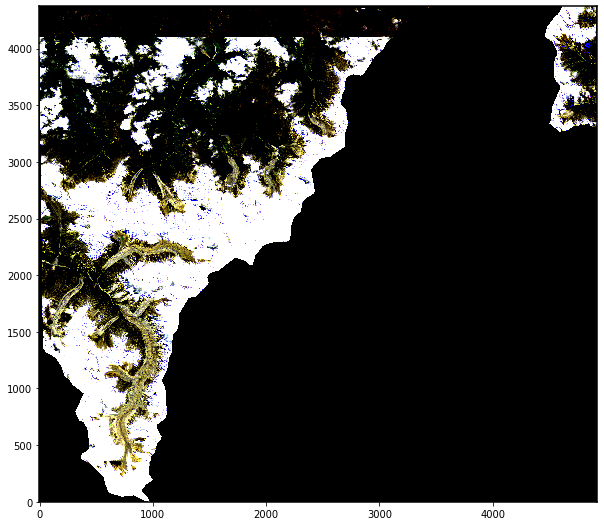

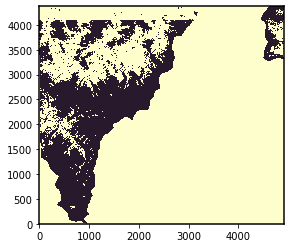

In [8]:
# Bands
# B1 Blue (.45-.52) Landsat | Sentinel B1 higher-res Ultra Blue (.443 central) or B2 (.49 central)
# B2 Green (.52-.60) | Sentinel B3 Green (.560)
# B3 Red (.63-.69) | Sentinel B4 Red (.665)
# B4 Near-IR (.77-.90) | Sentinel B5-B8a
# B5 Short-Wave IR (1.55-1.75) | B10 and B11
# B6 Thermal1 | ?
# B6 Thermal2 (10.40-12.50) | ? 
# B7 Mid-IR (2.08-2.35) | B12
# ["B1", "B2", "B3", "B4", "B5", "B6_VCID1", "B6_VCID2", "B7", "elevation", "slope"]

arr = tiff_np[:, :, [0, 2, 3, 6, 9, -1, -1, 11]]
arr = (arr - np.mean(arr)) / np.std(arr)


(4373, 4926, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


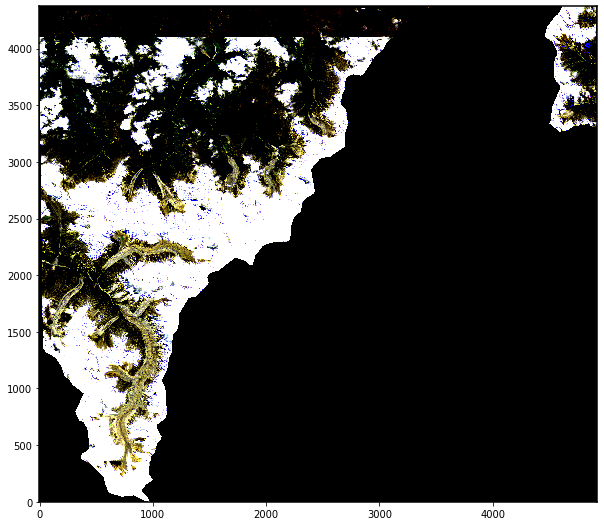

In [9]:
print(arr.shape)
plt.figure(figsize=(10, 10))
plt.imshow(arr[:, :, [2, 1, 0]])

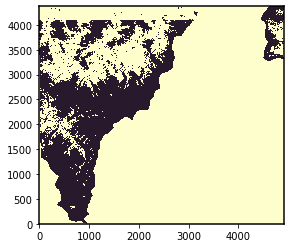

In [10]:
mask = np.sum(arr[:, :, :3], axis=2) < 0.01
plt.figure()
plt.imshow(mask)

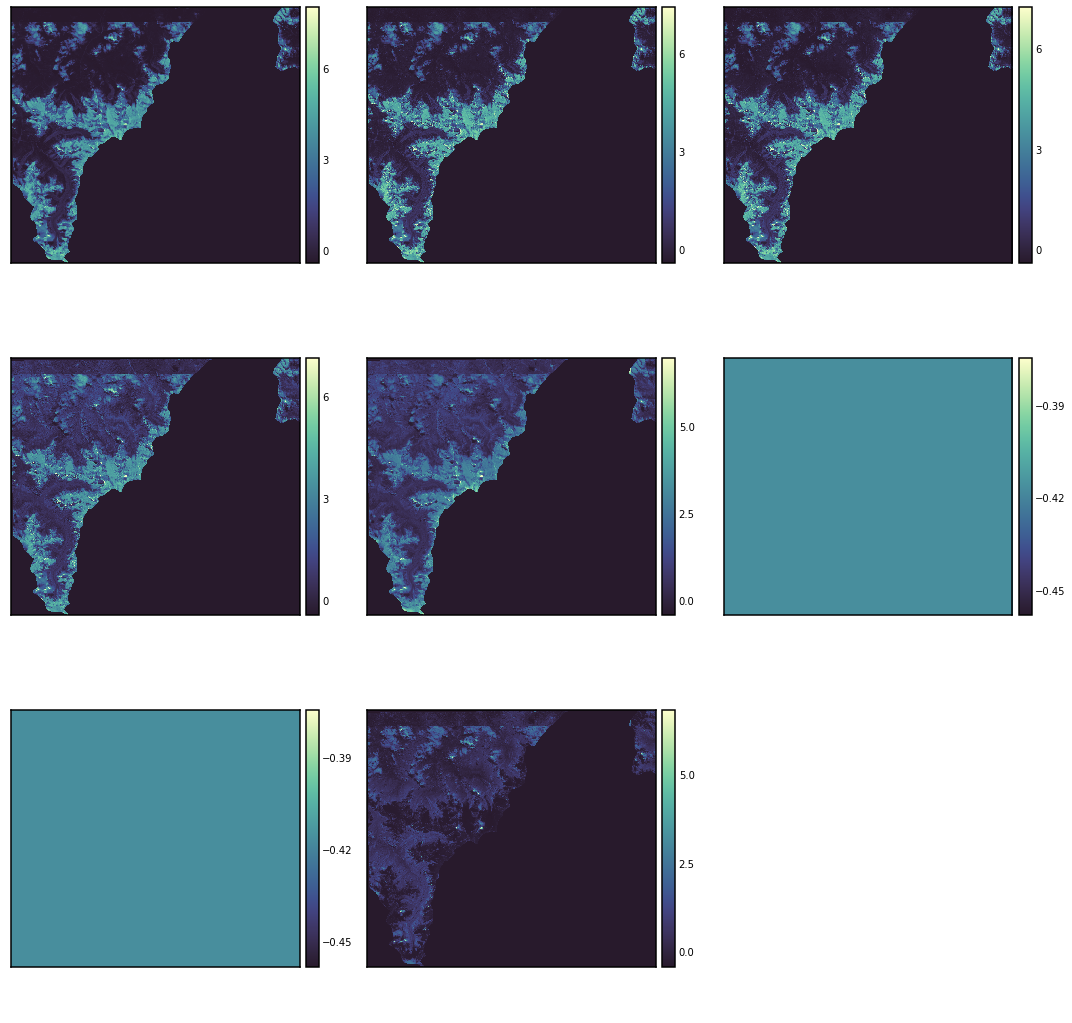

In [19]:
isns.ImageGrid(arr, height=5)

[0 1 2]


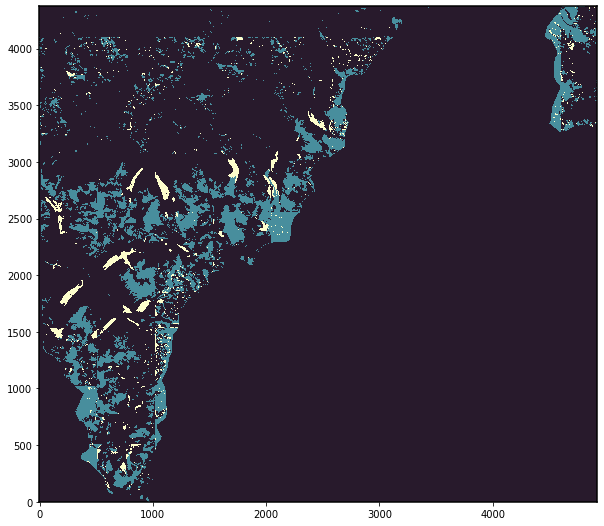

In [11]:
_x = torch.from_numpy(np.expand_dims(arr, axis=0)).float()
y_pred = np.zeros((arr.shape[0], arr.shape[1]), dtype=np.uint8)

for row in range(0, _x.shape[1], conf.window_size[0]):
# for row in [0]:
    for column in range(0, _x.shape[2], conf.window_size[1]):
    # for column in [0]:
        # Get slice
        current_slice = _x[:, row:row + conf["window_size"][0], column:column + conf["window_size"][1], :]
        if current_slice.shape[1] != conf.window_size[0] or current_slice.shape[2] != conf.window_size[1]:
            temp = np.zeros((1, conf.window_size[0], conf.window_size[1], _x.shape[3]))
            temp[:,:current_slice.shape[1],:current_slice.shape[2],:] = current_slice
            current_slice = torch.from_numpy(temp).float()

        # Slice prediction
        pred = frame.infer(current_slice)
        pred = torch.nn.Softmax(3)(pred)
        pred = np.squeeze(pred.cpu())

        y_pred = np.zeros((pred.shape[0], pred.shape[1]), dtype=np.uint8)
        for i in range(frame.num_classes):
            _class = pred[:, :, i] >= conf.threshold[i]
            _class = binary_fill_holes(_class)
            y_pred[_class] = i
        pred = y_pred

        # Place slice prediction into whole image prediction
        endrow_dest = row + conf.window_size[0]
        endrow_source = conf.window_size[0]
        endcolumn_dest = column + conf.window_size[0]
        endcolumn_source = conf.window_size[1]
        if endrow_dest > y_pred.shape[0]:
            endrow_source = y_pred.shape[0] - row
            endrow_dest = y_pred.shape[0]
        if endcolumn_dest > y_pred.shape[1]:
            endcolumn_source = y_pred.shape[1] - column
            endcolumn_dest = y_pred.shape[1]

        y_pred[row:endrow_dest, column:endcolumn_dest] = pred[0:endrow_source,0:endcolumn_source]

y_pred[mask] = 0
# y_true[mask] = 0
print(np.unique(y_pred))
# print(np.unique(y_true), frame.num_classes, y_pred.dtype)

plt.figure(figsize=(10, 10))
plt.imshow(y_pred)

# plt.figure(figsize=(10, 10))
# plt.imshow(y_true)

In [7]:
# all_tiff_fnames = list(tiff_path.glob('*.tif'))
# tiff_fname = tiff_path / all_tiff_fnames[1]
# dem_fname = dem_path / all_tiff_fnames[1]

# print(tiff_fname, df[df['Landsat ID'] == tiff_fname.name].iloc[0]['split'])

# assert tiff_fname.exists()
# assert dem_fname.exists()

# tiff_np = get_tiff_np(tiff_fname, dem_fname, physics_res=64, physics_scale=1, verbose=True)
# mask = np.sum(tiff_np[:, :, :3], axis=2) == 0
# tiff_np = tiff_np[:, :, use_channels]
# tiff_np = (tiff_np - _mean) / _std
# label_mask = get_mask(tiff_fname, labels)

# plt.figure(figsize=(10, 10))
# plt.imshow(tiff_np[:, :, [2, 1, 0]])

# y_true = np.zeros((label_mask.shape[0], label_mask.shape[1]))
# print(f'is_binary={is_binary}, binary_class={binary_class_idx}, label_mask={label_mask.shape}, y_true={y_true.shape}')

# if is_binary:
#     assert binary_class_idx != 0, 'You are trying to predict BG instead of CI or DCG'
#     y_true[label_mask[:, :, binary_class_idx-1] != 1] = 0
#     y_true[label_mask[:, :, binary_class_idx-1] == 1] = 1
# else:
#     for i in range(label_mask.shape[2]):
#         y_true[label_mask[:, :, i] == 1] = i + 1
# y_true = y_true.astype(np.uint8)
# y_true[mask] = 0
# print(y_true.shape, np.unique(y_true))
# plt.figure(figsize=(10, 10))
# plt.imshow(y_true)

In [13]:
with rasterio.Env():
    # Open TIFF file with rasterio
    src = read_tiff(tiff_fname)

    # You can use this to read the whole TIFF as an array if you want to create one with all the channels included
    # In this case we will only have the prediction channels
    # tiff_np = np.transpose(src.read(), (1, 2, 0)).astype(np.float32)
    # tiff_np = np.nan_to_num(tiff_np)
    profile = src.profile

    profile['dtype'] = str(y_pred.dtype)
    profile['height'] = y_pred.shape[0]
    profile['width'] = y_pred.shape[1]

    # assert profile['dtype'] in str(y_pred.dtype)
    # assert profile['height'] == y_pred.shape[0]
    # assert profile['width'] == y_pred.shape[1]

    # print(y_pred.shape, y_true.shape, tiff_np.shape)
    # print(y_pred.dtype, y_true.dtype, tiff_np.dtype)
    # st = np.dstack((tiff_np, y_pred, y_true))
    # print(st.shape)
    # st = np.moveaxis(st, [0, 1, 2], [2, 1, 0])
    # print(st.shape)

    # profile['dtype'] = 'float32'
    # profile['count'] = tiff_np.shape[2]+1
    profile['count'] = 1
    print(profile)
 
    # fname = f'{tiff_fname.stem}_pred_{conf.run_name}.tif'
    fname = 'image8_pred.tif'
    with rasterio.open(fname, 'w', **profile) as dst:
        # for i in range(tiff_np.shape[2]):
        #     dst.write(tiff_np[:, :, i], i+1)
        # dst.write(y_pred, i+1)
        # dst.write(y_true, i+2)
        dst.write(y_pred, 1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4926, 'height': 4373, 'count': 1, 'crs': CRS.from_epsg(32645), 'transform': Affine(10.0, 0.0, 364830.0,
       0.0, -10.0, 3141010.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


In [98]:
# print(tiff_fname, dem_fname)

/home/jperez/data/HKH_raw/Landsat7_2005/image87.tif /home/jperez/data/HKH_raw/Landsat7_2005/image87.tif


In [4]:
df = pd.read_csv('/home/jperez/data/HKH/processed_L07_2005_phys64_s1/slice_meta.csv')
print(np.load('/home/jperez/data/HKH/processed_L07_2005_phys64_s1/train/tiff_103_slice_11.npy').shape)
df

(512, 512, 11)


,Landsat ID,Image,Slice,Background,Clean Ice,Debris,Masked,Background Percentage,Clean Ice Percentage,Debris Percentage,Masked Percentage,split
0,image106.tif,0,2,219002,33329,6118,3695,0.835426,0.127140,0.023338,0.014095,test
1,image106.tif,0,12,235367,25252,1525,0,0.897854,0.096329,0.005817,0.000000,test
2,image106.tif,0,17,221650,40252,0,242,0.845528,0.153549,0.000000,0.000923,test
3,image112.tif,2,5,132074,23762,1998,104310,0.503822,0.090645,0.007622,0.397911,test
4,image112.tif,2,7,125399,33082,2203,101460,0.478359,0.126198,0.008404,0.387039,test
...,...,...,...,...,...,...,...,...,...,...,...,...
466,image96.tif,140,6,199186,49042,13916,0,0.759834,0.187080,0.053085,0.000000,train
467,image96.tif,140,7,148193,103689,10262,0,0.565311,0.395542,0.039146,0.000000,train
468,image96.tif,140,8,96909,45202,5583,114450,0.369678,0.172432,0.021297,0.436592,train
469,image96.tif,140,11,218673,40813,2658,0,0.834171,0.155689,0.010139,0.000000,train


In [4]:
df = pd.read_csv('/home/jperez/data/HKH/processed_L07_2005/slice_meta.csv')
print(np.load('/home/jperez/data/HKH/processed_L07_2005/train/tiff_103_slice_11.npy').shape)
df

(512, 512, 10)


,Landsat ID,Image,Slice,Background,Clean Ice,Debris,Masked,Background Percentage,Clean Ice Percentage,Debris Percentage,Masked Percentage,split
0,image106.tif,0,2,218969,33197,6110,3868,0.835300,0.126637,0.023308,0.014755,test
1,image106.tif,0,12,235367,25252,1525,0,0.897854,0.096329,0.005817,0.000000,test
2,image106.tif,0,17,221636,40238,0,270,0.845474,0.153496,0.000000,0.001030,test
3,image112.tif,2,5,131407,23699,1998,105040,0.501278,0.090405,0.007622,0.400696,test
4,image112.tif,2,7,124814,33082,2203,102045,0.476128,0.126198,0.008404,0.389271,test
...,...,...,...,...,...,...,...,...,...,...,...,...
466,image96.tif,140,6,199186,49042,13916,0,0.759834,0.187080,0.053085,0.000000,train
467,image96.tif,140,7,148193,103689,10262,0,0.565311,0.395542,0.039146,0.000000,train
468,image96.tif,140,8,96657,45118,5580,114789,0.368717,0.172112,0.021286,0.437885,train
469,image96.tif,140,11,218673,40813,2658,0,0.834171,0.155689,0.010139,0.000000,train


In [55]:
# after running predict_slices.py
D = {i:list() for i in range(frame.num_classes)}

D_split = {}
pred_dir = pathlib.Path('pred_runs/images/multi_phys64_s1/')
all_pred_fnames = list(pred_dir.glob('*.tif'))
for pred_fname in all_pred_fnames:
    s = pred_fname.name.split('_')
    im_fname = s[0]
    split = s[1][:-4]
    D_split[im_fname] = split

print(D_split)

df = pd.DataFrame(columns=['fname', 'total_n', 'bg_n', 'bg_n%', 'bg_iou', 'ci_n', 'ci_n%', 'ci_iou', 'dci_n', 'dci_n%', 'dci_iou'])

for idx, fname in enumerate(tqdm(list(tiff_path.glob('*.tif')))):
    tiff_fname = tiff_path / fname.name
    split = D_split[fname.name[:-4]]
    pred_fname =  pred_dir/ f'{fname.stem}_{split}.tif'
    dem_fname = dem_path / fname

    assert tiff_fname.exists()
    assert pred_fname.exists()
    assert dem_fname.exists()

    im_tiff = np.transpose(read_tiff(tiff_fname).read(), (1, 2, 0)).astype(np.uint8)
    pred_tiff = np.transpose(read_tiff(pred_fname).read(), (1, 2, 0)).astype(np.uint8)
    mask = np.sum(pred_tiff[:, :, :3], axis=2) < 0.01
    # plt.figure()
    # plt.imshow(pred_tiff)
    # plt.figure()
    # plt.imshow(mask)
    # print(np.unique(pred_tiff))

    label_mask = get_mask(tiff_fname, labels)
    y_true = np.zeros((label_mask.shape[0], label_mask.shape[1]))
    for i in range(label_mask.shape[2]):
        y_true[label_mask[:, :, i] == 1] = i + 1
    y_true = y_true.astype(np.uint8)
    y_true[mask] = 0
    # plt.figure()
    # plt.imshow(y_true)
    # print(np.unique(y_true))

    total_pixels = pred_tiff.shape[0] * pred_tiff.shape[1]
    row = [fname.stem, total_pixels]
    for i in range(frame.num_classes):
        p = np.zeros((pred_tiff.shape[0], pred_tiff.shape[1]), dtype=np.uint8)
        t = np.zeros_like(p)

        p[pred_tiff[:,:, 0] == i] = 1
        t[y_true == i] = 1

        class_total = np.sum(p)
        class_percent = class_total / total_pixels

        tp, fp, fnn = get_tp_fp_fn(p, t)
        prec, rec, iou = get_precision_recall_iou(tp, fp, fnn)

        row.extend([class_total, class_percent, iou])
        # D[i].append((fname.stem, class_total, iou))
        # print(prec, rec, iou, f'{class_percent:.2f}%', class_total)
    df.loc[len(df.index)] = row

df.to_csv('pred.csv')
print(df)

{'image36': 'train', 'image69': 'ignored', 'image38': 'ignored', 'image84': 'train', 'image34': 'ignored', 'image70': 'train', 'image172': 'ignored', 'image197': 'train', 'image74': 'ignored', 'image165': 'train', 'image128': 'ignored', 'image33': 'train', 'image9': 'train', 'image92': 'train', 'image98': 'test', 'image184': 'ignored', 'image144': 'train', 'image16': 'test', 'image193': 'train', 'image79': 'train', 'image117': 'train', 'image163': 'ignored', 'image137': 'ignored', 'image67': 'ignored', 'image154': 'train', 'image72': 'test', 'image167': 'ignored', 'image87': 'train', 'image15': 'train', 'image115': 'val', 'image47': 'ignored', 'image104': 'ignored', 'image145': 'train', 'image190': 'ignored', 'image96': 'train', 'image134': 'train', 'image151': 'ignored', 'image192': 'test', 'image122': 'ignored', 'image50': 'train', 'image49': 'train', 'image200': 'val', 'image155': 'train', 'image181': 'train', 'image153': 'ignored', 'image100': 'ignored', 'image147': 'ignored', 'ima

  0%|          | 0/202 [00:00<?, ?it/s]/home/jperez/miniconda3/envs/pytorch/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/jperez/miniconda3/envs/pytorch/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/jperez/miniconda3/envs/pytorch/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax 

        fname  total_n     bg_n     bg_n%    bg_iou    ci_n     ci_n%  \
0    image180  2304896  2043026  0.886385  0.899287  242682  0.105290   
1     image87  2795136  1979720  0.708273  0.903761  800170  0.286272   
2     image86  2783556  2130958  0.765552  0.883666  642581  0.230849   
3    image158  2511600  2279425  0.907559  0.942906  224607  0.089428   
4     image37  3010345  2568431  0.853202  0.859785  424717  0.141086   
..        ...      ...      ...       ...       ...     ...       ...   
197  image156  3087399  2637134  0.854160  0.859377  429636  0.139158   
198   image13  3080550  2353368  0.763944  0.763997  708009  0.229832   
199   image71  2944287  2525235  0.857673  0.931895  416130  0.141335   
200    image6    57783    47430  0.820830  0.861533    6700  0.115951   
201   image30  3067202  2547688  0.830623  0.902614  494839  0.161332   

       ci_iou  dci_n    dci_n%   dci_iou  
0    0.126490  19188  0.008325  0.001427  
1    0.738042  15246  0.005454  0.007

In [69]:
df.sort_values(by=['dci_n', 'dci_iou'], ascending=False)

,fname,total_n,bg_n,bg_n%,bg_iou,ci_n,ci_n%,ci_iou,dci_n,dci_n%,dci_iou
47,image12,3159468,2558083,0.809656,0.826499,564591,0.178698,0.111058,36794,0.011646,0.000026
23,image124,2785336,2045473,0.734372,0.809069,705016,0.253117,0.331214,34847,0.012511,0.038428
66,image92,2517933,2242929,0.890782,0.925437,241798,0.096030,0.383944,33206,0.013188,0.000000
133,image161,2685837,2061436,0.767521,0.808042,593139,0.220840,0.213585,31262,0.011640,0.005050
160,image35,2921478,2008510,0.687498,0.695304,883256,0.302332,0.036050,29712,0.010170,0.000493
...,...,...,...,...,...,...,...,...,...,...,...
34,image105,166110,146855,0.884083,0.944338,17514,0.105436,0.576349,1741,0.010481,0.000000
184,image191,395275,348728,0.882241,0.901889,44825,0.113402,0.186307,1722,0.004356,0.000000
58,image188,33704,24653,0.731456,0.773306,7517,0.223030,0.242650,1534,0.045514,0.000000
149,image131,332975,306864,0.921583,0.923972,24858,0.074654,0.021400,1253,0.003763,0.000000


      fname  total_n     bg_n     bg_n%    bg_iou    ci_n     ci_n%    ci_iou  \
47  image12  3159468  2558083  0.809656  0.826499  564591  0.178698  0.111058   

    dci_n    dci_n%   dci_iou  
47  36794  0.011646  0.000026  


/home/jperez/miniconda3/envs/pytorch/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/jperez/miniconda3/envs/pytorch/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/jperez/miniconda3/envs/pytorch/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is 

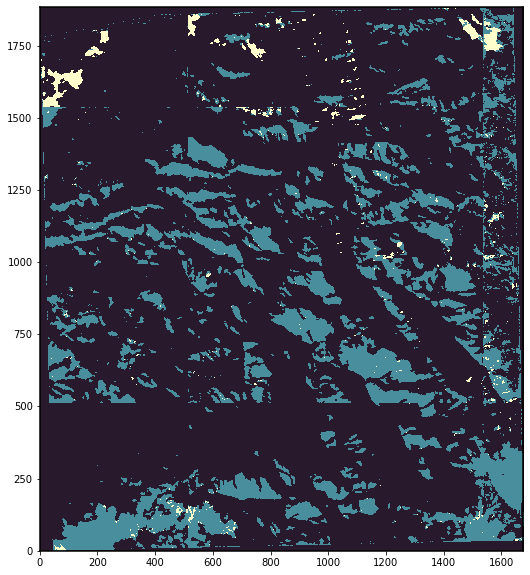

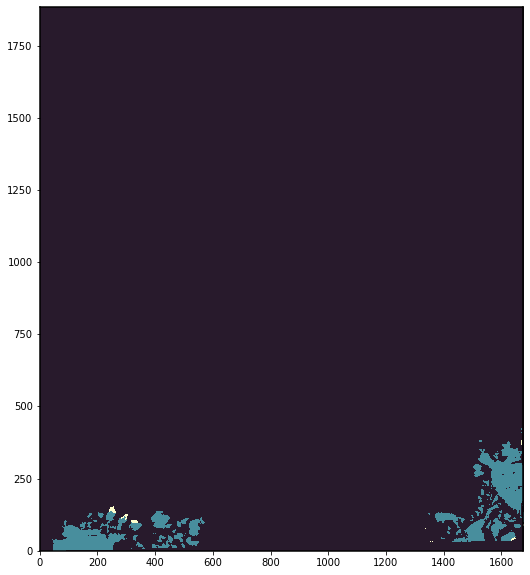

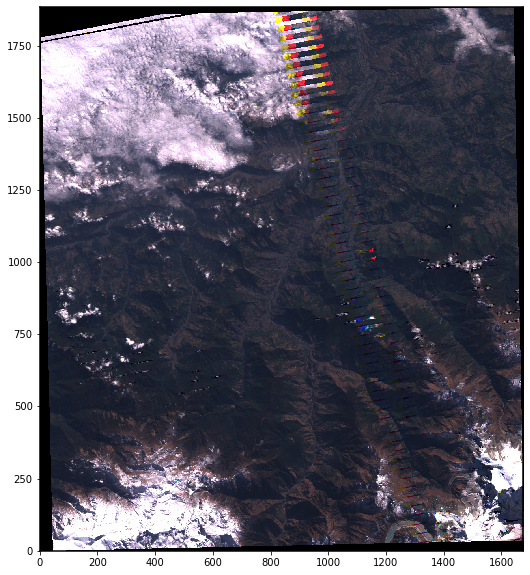

In [70]:
fname = pathlib.Path('image12.tif')
print(df[df['fname']==fname.stem])

tiff_fname = tiff_path / fname.name
split = D_split[fname.name[:-4]]
pred_fname =  pred_dir/ f'{fname.stem}_{split}.tif'
dem_fname = dem_path / fname

assert tiff_fname.exists()
assert pred_fname.exists()
assert dem_fname.exists()

im_tiff = np.transpose(read_tiff(tiff_fname).read(), (1, 2, 0)).astype(np.uint8)
pred_tiff = np.transpose(read_tiff(pred_fname).read(), (1, 2, 0)).astype(np.uint8)
mask = np.sum(pred_tiff[:, :, :3], axis=2) < 0.01
# plt.figure()
# plt.imshow(pred_tiff)
# plt.figure()
# plt.imshow(mask)
# print(np.unique(pred_tiff))

label_mask = get_mask(tiff_fname, labels)
y_true = np.zeros((label_mask.shape[0], label_mask.shape[1]))
for i in range(label_mask.shape[2]):
    y_true[label_mask[:, :, i] == 1] = i + 1
y_true = y_true.astype(np.uint8)
y_true[mask] = 0

plt.figure(figsize=(10,10))
plt.imshow(pred_tiff)
plt.figure(figsize=(10, 10))
plt.imshow(y_true)
plt.figure(figsize=(10, 10))
plt.imshow(im_tiff[:, :, [2, 1, 0]])